In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

/home/aniscorp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
from sklearn.linear_model import LinearRegression

def data_treatement(folder_path):
    dataframe = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path,file_name)
        if os.path.isfile(file_path) and file_name.endswith('txt'):
            df = pd.read_csv(file_path,sep=';')
            df['DateJ'] = pd.to_datetime(df['DateJ'],format='%Y-%m-%d')
            df['DateJ'] = df['DateJ'].dt.to_period('M')
            dataframe.append(df)
    final_df = pd.concat(dataframe,ignore_index=True)
    final_df['mobile'] = final_df['mobile trafic'].combine_first(final_df['mobile souscription'])
    rows = final_df[final_df['mobile'].isna()]
    final_df['CA_SOUSCRIPTION'] = final_df['CA_SOUSCRIPTION'].str.replace(',','.')
    final_df['CA_TRAFFIC'] = final_df['CA_TRAFFIC'].str.replace(',','.')
    final_df.fillna({'CA_SOUSCRIPTION':0.0, 'CA_TRAFFIC': 0.0},inplace=True)
    final_df = final_df.astype({'CA_SOUSCRIPTION':'float', 'CA_TRAFFIC':'float'})
    final_df.drop(index=rows.index.to_list(), inplace=True)
    final_df['CA'] = final_df['CA_SOUSCRIPTION'] + final_df['CA_TRAFFIC']
    # final_df['CA'] = final_df[final_df['CA'] > 0]
    final_df = final_df.astype({'mobile':'int64'})
    final_df = final_df.astype({'mobile':'category'})
    data_final = final_df.drop(columns={'mobile trafic','mobile souscription','CA_TRAFFIC','CA_SOUSCRIPTION'})
    data_final_sup = data_final[data_final['CA'] > 0]
    data_pivoted = data_final_sup.pivot(index='DateJ',columns='mobile',values='CA')
    data_pivoted.columns.name = None
    data_pivoted.index.name = None
    data_pivoted.fillna(0.0,axis=1,inplace=True)
    return data_pivoted,data_final  

folder_path = '/path_to_ca_revenue_files/CA_REVENUE/' #change this folder path to yours where you revenue files are
result_df = data_treatement(folder_path)
data_pivoted,data_final  = result_df

# Analyse de tendance pour chaque numero
trends = {}
for col in data_pivoted.columns:
    x = np.arange(len(data_pivoted)).reshape(-1, 1)  # mois (0, 1, 2, ...)
    y = data_pivoted[col].values  # Contributions
    model = LinearRegression()
    model.fit(x, y)
    trends[col] = model.coef_[0]  # Pente de la droite de régression (tendance)

# Résultats
trend_df = pd.DataFrame({'Number': trends.keys(), 'Trend': trends.values()})
trend_df = trend_df.sort_values(by='Trend', ascending=True)

#Tendances des numeros en baisse
trend_df_baisse = trend_df[trend_df['Trend'] < 0]
trend_df_baisse.to_csv('numero_tendances_baisse.csv',index=False) #this files is saved to your actual directory

#Tendances des numeros en hausse
trend_df_hausse = trend_df[trend_df['Trend'] > 0]
trend_df_hausse.to_csv('numero_tendances_hausse.csv',index=False)  #this files is saved to your actual directory

pd.options.display.float_format= '{:.6f}'.format


# Define the maximum allowed rows for Excel
MAX_ROWS_EXCEL = 1040000  # Excel's row limit

# Load your data into a DataFrame
# Replace '/path_to_/' with your actual file path
df = pd.read_csv('/path_to_/numero_tendances_hausse.csv')
df1 = pd.read_csv('/path_to/numero_tendances_baisse.csv')

# Function to split and save the DataFrame
def split_and_save(df, df1, max_rows, base_filename):
    num_files = 0
    num_file = 0

    # Process df
    if df.shape[0] > max_rows:
        for i in range(0, df.shape[0], max_rows):
            new_df = df.iloc[i:i + max_rows]
            
            #You must create a  folder named 'tendance_hausse_split' 
            new_filename = f"/path_to/tendance_hausse_split/{base_filename}_hause_{num_files + 1}.csv"
            new_df.to_csv(new_filename, index=False)
            print(f"Saved {new_filename} with shape {new_df.shape}")
            num_files += 1
    else:
        df.to_csv(f"/path_to/tendance_hausse_split/{base_filename}.csv", index=False)
        print(f"Saved {base_filename}.csv with shape {df.shape}")

    # Process df1
    if df1.shape[0] > max_rows:
        for i in range(0, df1.shape[0], max_rows):
            new_df = df1.iloc[i:i + max_rows]
            #You must create a  folder named 'tendance_baisse_split' 
            new_filename = f"/path_to/tendance_baisse_split/{base_filename}_baisse_{num_file + 1}.csv"
            new_df.to_csv(new_filename, index=False)
            print(f"Saved {new_filename} with shape {new_df.shape}")
            num_file += 1
    else:
        df1.to_csv(f"/path_to/tendance_baisse_split/{base_filename}.csv", index=False)
        print(f"Saved {base_filename}.csv with shape {df1.shape}")

# Call the function to split and save the DataFrame
split_and_save(df,df1, MAX_ROWS_EXCEL, 'num')


#Exportation to excel files
folder_path_hausse = "/path_to/tendance_hausse_split/" #folder path to where tendances hausse files are

with pd.ExcelWriter('/path_to/numero_en_hausse_Jan_Nov_2024.xlsx',engine='openpyxl') as writer:

    for file_name in os.listdir(folder_path_hausse) :

        file_path = os.path.join(folder_path_hausse,file_name)
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)
            sheet_name = os.path.splitext(file_name)[0]
            # Write the DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Added sheet '{sheet_name}' from file '{file_name}'")


folder_path_baisse = "/path_to/tendance_baisse_split/" #folder path to where tendances baisse files are

with pd.ExcelWriter('/path_to/numero_en_baisse_Jan_Nov_2024.xlsx',engine='openpyxl') as writer:

    for file_name in os.listdir(folder_path_baisse) :

        file_path = os.path.join(folder_path_baisse,file_name)
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)
            sheet_name = os.path.splitext(file_name)[0]
            # Write the DataFrame to a new sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Added sheet '{sheet_name}' from file '{file_name}'")



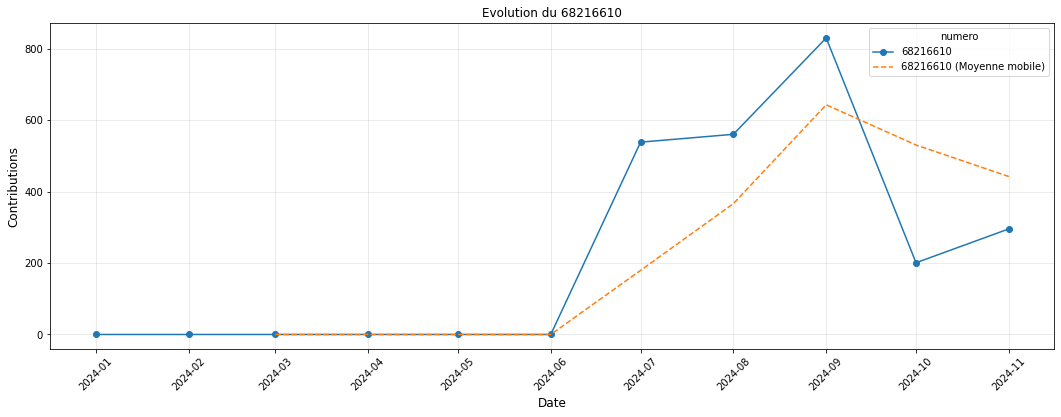

In [2]:
data_plot = data_pivoted[[68216610]]


plt.figure(figsize=(18,6))
for col in data_plot.columns:
    plt.plot(data_plot.index.to_timestamp(),data_plot[col],marker = 'o',label=col)

# Calcul et affichage des moyennes mobiles
for col in data_plot.columns:
    rolling_mean = data_plot[col].rolling(window=3).mean()
    plt.plot(data_plot.index.to_timestamp(), rolling_mean, linestyle='--', label=f'{col} (Moyenne mobile)')



plt.title(f"Evolution du {data_plot.columns[0]}")
plt.xlabel("Date",fontsize=12)
plt.ylabel("Contributions",fontsize=12)
plt.legend(title="numero")

plt.grid(alpha=0.3)
plt.xticks(rotation = 45)
plt.show()